In [10]:
# Load packages bigsnpr and bigstatsr
library(bigsnpr)
library(tidyverse)

# Load bigSNP objects in R session
cat('\nLoading bigSNP objects...')
for (chr in 1:22) {
    cat(paste('\nCurrently working on chromosome',chr))
    obj.bigSNP <- snp_attach(paste0("/mnt/stsi/stsi1/ptseng/UKBB_Resources/ldpred2/chr",chr,"/temp.rds"))
    #str(obj.bigSNP, max.level = 2, strict.width = "cut")
  
    if (chr == 1) {
        G   <- c(obj.bigSNP$genotypes)
        map <- obj.bigSNP$map
    } else {
        G   <- append(G,obj.bigSNP$genotypes)
        map <- bind_rows(map,obj.bigSNP$map)
    }
}

# Fixing column values
map$chromosome <- as.integer(map$chromosome)
map$physical.pos <- as.integer(map$physical.pos)

cat('\nDONE\n')


# Get aliases for useful slots
CHR <- map$chromosome
ind.N <- nrow(G[[1]])
NCORES <- nb_cores()

# Set individuals
ind.val <- sample(ind.N, ind.N*4/5)
ind.test <- setdiff(ind.N, ind.val)

# Read external summary statistics
cat('\nLoading summary statistics...')
sumstats <- bigreadr::fread2("../PD.sumstats.reduced")
cat('\nDONE\n')

# Matching Sumstats with Map
cat('\nMatching summary statistics with map data...')
sumstats <- sumstats[,c('CHR', 'POS', 'A1', 'A2', 'EAF', 'Beta', 'se')]
names(sumstats) <- c("chr", "pos", "a0", "a1", "a1_freq", "beta", "se")
sumstats['n_eff'] <- ind.N

map <- map[,c('chromosome','physical.pos','allele1','allele2')]
names(map) <- c("chr", "pos", "a0", "a1")

info_snp <- snp_match(sumstats, map)
info_snp <- tidyr::drop_na(tibble::as_tibble(info_snp))
cat('\nDONE\n')

# Set Temporary File
tmp <- tempfile(tmpdir = "tmp-data")


Loading bigSNP objects...
Currently working on chromosome 1
Currently working on chromosome 2
Currently working on chromosome 3
Currently working on chromosome 4
Currently working on chromosome 5
Currently working on chromosome 6
Currently working on chromosome 7
Currently working on chromosome 8
Currently working on chromosome 9
Currently working on chromosome 10
Currently working on chromosome 11
Currently working on chromosome 12
Currently working on chromosome 13
Currently working on chromosome 14
Currently working on chromosome 15
Currently working on chromosome 16
Currently working on chromosome 17
Currently working on chromosome 18
Currently working on chromosome 19
Currently working on chromosome 20
Currently working on chromosome 21
Currently working on chromosome 22
DONE

Loading summary statistics...
DONE

Matching summary statistics with map data...

3,889,194 variants to be matched.

584,925 ambiguous SNPs have been removed.

Some duplicates were removed.

3,303,049 variants have been matched; 0 were flipped and 0 were reversed.




DONE


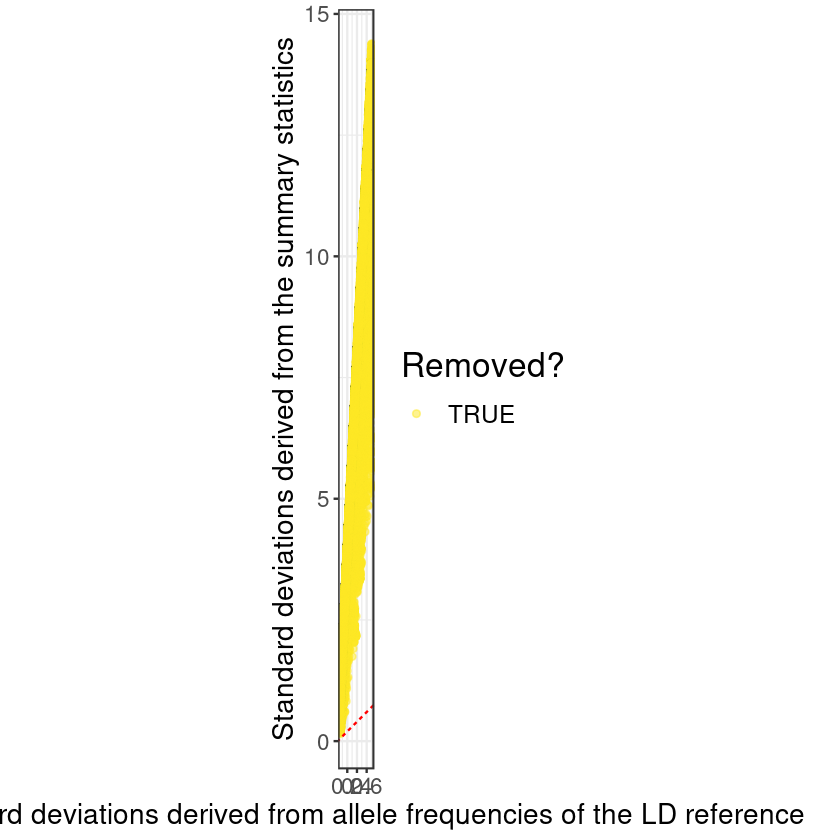

In [34]:
sd_ldref <- with(info_snp, sqrt(2 * a1_freq * (1 - a1_freq)))
sd_ss <- with(info_snp, 2 / sqrt(n_eff * se^2))

is_bad <-
  sd_ss < (0.5 * sd_ldref) | sd_ss > (sd_ldref + 0.1) | sd_ss < 0.1 | sd_ldref < 0.05

library(ggplot2)
qplot(sd_ldref, sd_ss, color = is_bad, alpha = I(0.5)) +
  theme_bigstatsr() +
  coord_equal() +
  scale_color_viridis_d(direction = -1) +
  geom_abline(linetype = 2, color = "red") +
  labs(x = "Standard deviations derived from allele frequencies of the LD reference",
       y = "Standard deviations derived from the summary statistics",
       color = "Removed?")

df_beta <- info_snp[!is_bad, ]

In [33]:
df_beta

chr,pos,a0,a1,a1_freq,beta,se,n_eff,_NUM_ID_.ss,_NUM_ID_
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,853805,C,T,0.9823520,0.001033650,0.000781655,487409,201,201
1,854429,G,A,0.9822820,0.001052330,0.000779698,487409,203,203
1,857177,T,C,0.9808450,0.001409100,0.000750304,487409,208,208
1,860461,G,A,0.0198220,-0.001252600,0.000734994,487409,212,212
1,860521,C,A,0.0198189,-0.001272930,0.000735061,487409,213,213
1,861808,A,G,0.0198184,-0.001247390,0.000735027,487409,216,216
1,862093,T,C,0.0198268,-0.001254310,0.000734782,487409,217,217
1,862124,A,G,0.0200019,-0.001236710,0.000731485,487409,218,218
1,862383,C,T,0.0198211,-0.001249200,0.000734955,487409,219,219


In [14]:
info_snp

chr,pos,a0,a1,a1_freq,beta,se,n_eff,_NUM_ID_.ss,_NUM_ID_
<int>,<int>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,55326,T,C,0.99155100,0.003083870,0.002005890,487409,1,1
1,79033,A,G,0.00129077,-0.005263570,0.004622200,487409,2,2
1,544584,C,T,0.99811000,0.003366280,0.003289800,487409,3,3
1,565196,T,C,0.99769000,0.004474510,0.003491760,487409,4,4
1,568800,G,A,0.98306800,0.001604060,0.001385250,487409,5,5
1,710445,A,G,0.99880200,0.005329060,0.003916400,487409,7,7
1,713092,G,A,0.99792700,0.004355920,0.002690470,487409,8,8
1,714277,C,A,0.99252200,0.001869840,0.001591520,487409,9,9
1,714596,T,C,0.96710600,0.000756802,0.000635953,487409,10,10


In [55]:
# Load Correlation Info from File
cat('\nLoading correlation info...')
for (chr in 1:22) {

  # print(chr)

  ## indices in 'sumstats'
  cat('\nind-1\n')
  ind.chr1 <- which(sumstats$chr == chr)
  str(ind.chr1)
  ## indices in 'G'
  cat('\nind-2\n')
  ind.chr2 <- matched_stats$`_NUM_ID_`[ind.chr1]
  str(ind.chr2)
  ## indices in 'corr'
  cat('\nind-3\n')
  ind.chr3 <- match(ind.chr2, which(CHR == chr))
  str(ind.chr3)
    
  cat(paste('\nreadRDS for chromosome',chr))
  corr0 <- readRDS(paste0("/mnt/stsi/stsi1/ptseng/LD_ref_European_privefl/LD_chr", chr, ".rds"))[ind.chr3, ind.chr3]

  if (chr == 1) {
    df_beta <- sumstats[ind.chr1, c("beta", "beta_se", "n_eff", "_NUM_ID_")]
    ld <- Matrix::colSums(corr0^2)
    corr <- as_SFBM(corr0, tmp)
  } else {
    df_beta <- rbind(df_beta, sumstats[ind.chr1, c("beta", "beta_se", "n_eff", "_NUM_ID_")])
    ld <- c(ld, Matrix::colSums(corr0^2))
    corr$add_columns(corr0, nrow(corr))
  }
}
cat('\nDONE\n')


Loading correlation info...
ind-1
 int [1:300383] 1 2 3 4 5 6 7 8 9 10 ...

ind-2
 int [1:300383] 1 2 3 4 5 7 8 9 10 12 ...

ind-3
 int [1:300383] 1 2 3 4 5 7 8 9 10 12 ...

readRDS for chromosome 1

ERROR: Error in intI(i, n = d[1], dn[[1]], give.dn = FALSE): 'NA' indices are not (yet?) supported for sparse Matrices


In [ ]:
(ldsc <- with(df_beta, snp_ldsc(ld, length(ld), chi2 = (beta / beta_se)^2,
                                  sample_size = n_eff, blocks = NULL)))
h2_est <- ldsc[["h2"]]

In [ ]:
# ldpred2 auto
multi_auto <- snp_ldpred2_auto(corr, df_beta, h2_init = h2_est,
                               vec_p_init = seq_log(1e-4, 0.9, 30),
                               ncores = NCORES)
beta_auto <- sapply(multi_auto, function(auto) auto$beta_est)
pred_auto <- big_prodMat(G, beta_auto, ind.row = ind.val,
                         ind.col = df_beta[["_NUM_ID_"]])
sc <- apply(pred_auto, 2, sd)
keep <- abs(sc - median(sc)) < 3 * mad(sc)
final_beta_auto <- rowMeans(beta_auto[, keep])

In [ ]:
# compute predictions for test set
pred_test <- big_prodMat(G, final_beta_auto, ind.row = ind.test,
                         ind.col = df_beta[["_NUM_ID_"]])

In [ ]:
# save results
res <- list(pred = setNames(as.data.frame(pred_test), colnames(betas)),
            params = params, auto = multi_auto[keep])
saveRDS(res, '/gpfs/home/ptseng/Torkamani_Projects/20210602_regenie-UKBB/ldpred2_result')